In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.stats import jarque_bera

In [11]:
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None) # show full width of showing cols
pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be
pd.options.display.max_seq_items = 200000

In [12]:
DF = pd.read_excel('data/data8.xls')

In [13]:
# Percent of rented properties
DF['pctrnths'] = DF['rnthsg'] / DF['tothsg'] * 100

# Logarithm of percent of rented properties
DF['lpctrnths'] = np.log(DF['pctrnths'])

# Squared average income
DF['avgincsq'] = DF['avginc'] **2

In [14]:
DF80 = DF[DF['year'] == 80]
DF90 = DF[DF['year'] == 90]

In [15]:
# Calculate the diff for logarithm of change in percent of rented properties (lpctrnths)
pivot_df = DF.pivot(index='city', columns='year', values='lpctrnths')
pivot_df['clpctrnths'] = pivot_df[90] - pivot_df[80]
result_df = pivot_df.reset_index()

# Add new column 'clpctrnths' to DF90
DF90 = pd.merge(DF90,result_df,on='city',how='left')

## Simple linear regression with average income as only regressor

In [16]:
# Simple linear regression with average income as only regressor
X80 = DF80['avginc']
y80 = DF80['rent']
model80 = sm.OLS(y80, sm.add_constant(X80)).fit()

print("##### Linear regression for 1980 #######")
print(model80.summary())

X90 = DF90['avginc']
y90 = DF90['rent']
model90 = sm.OLS(y90, sm.add_constant(X90)).fit()

print()
print("##### Linear regression for 1990 #######")
print(model90.summary())

##### Linear regression for 1980 #######
                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     121.2
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           3.18e-16
Time:                        12:13:14   Log-Likelihood:                -296.49
No. Observations:                  64   AIC:                             597.0
Df Residuals:                      62   BIC:                             601.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

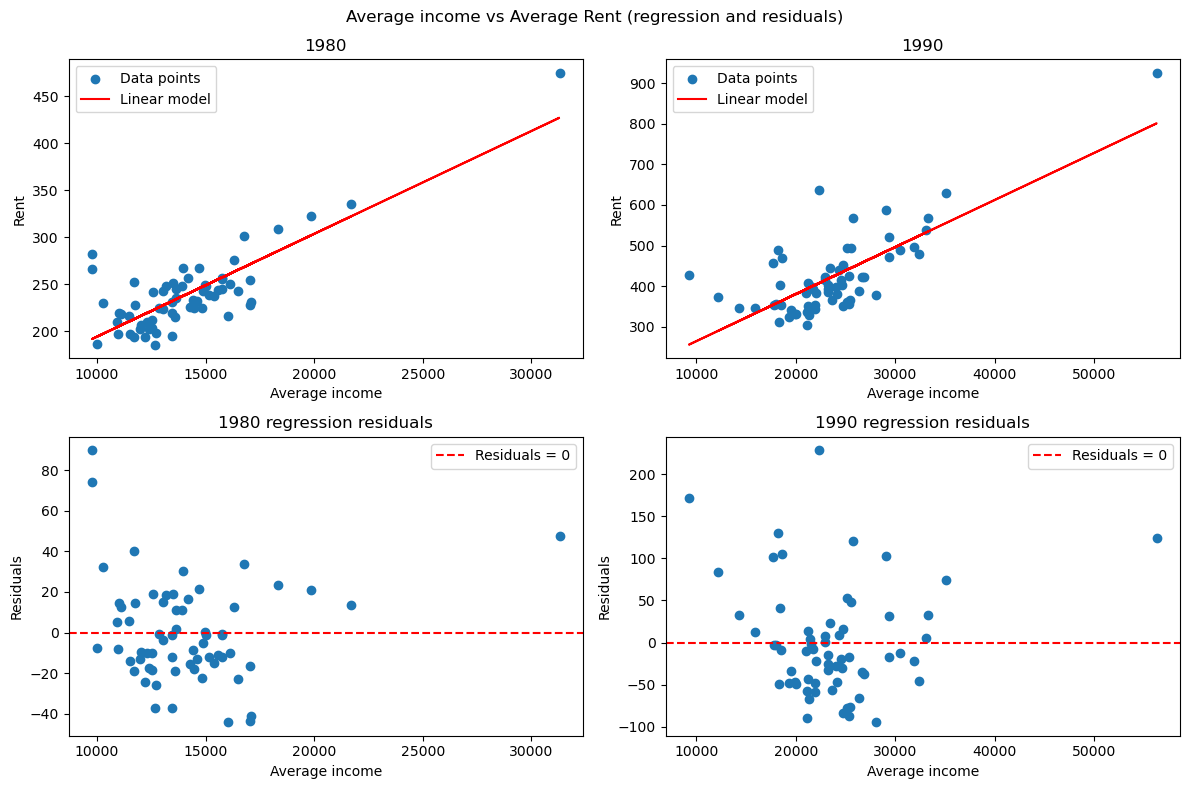

In [17]:
# Plot linear regression and its residuals
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

ax1.scatter(X80, y80, label='Data points')
ax1.plot(X80, model80.params.const + model80.params.avginc * X80, label='Linear model', color='red')

ax2.scatter(X90, y90, label='Data points')
ax2.plot(X90, model90.params.const + model90.params.avginc * X90, label='Linear model', color='red')

ax3.scatter(X80, model80.resid)
ax3.axhline(y=0, color='r', linestyle='--', label='Residuals = 0')

ax4.scatter(X90, model90.resid)
ax4.axhline(y=0, color='r', linestyle='--', label='Residuals = 0')

ax1.set_title('1980')
ax1.set_xlabel("Average income")
ax1.set_ylabel("Rent")
ax1.legend()

ax2.set_title('1990')
ax2.set_xlabel("Average income")
ax2.set_ylabel("Rent")
ax2.legend()

ax3.set_title('1980 regression residuals')
ax3.set_xlabel("Average income")
ax3.set_ylabel("Residuals")
ax3.legend()

ax4.set_title('1990 regression residuals')
ax4.set_xlabel("Average income")
ax4.set_ylabel("Residuals")
ax4.legend()

plt.suptitle('Average income vs Average Rent (regression and residuals)')
plt.tight_layout()
plt.show()

## Multiple linear regression with following regressors: population, percent students, percent rented properties, average income

In [18]:
# Adding more parameters to linear regression to improve the fit of the model (1980)
X80 = DF80[['pop', 'pctstu', 'pctrnths', 'avginc']]
y80 = DF80['rent']

model80ex = sm.OLS(y80, X80).fit()
y80pred = X80 @ model80ex.params.values

print(model80ex.summary())

# Adding more parameters to linear regression to improve the fit of the model (1990)
X90 = DF90[['pop', 'pctstu', 'pctrnths', 'avginc']]
y90 = DF90['rent']

model90ex = sm.OLS(y90, X90).fit()
y90pred = X90 @ model90ex.params.values

print(model90ex.summary())

# test for multicollinearity - variance inflation factor

                                 OLS Regression Results                                
Dep. Variable:                   rent   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              2340.
Date:                Mon, 22 Jan 2024   Prob (F-statistic):                    4.10e-65
Time:                        12:13:14   Log-Likelihood:                         -280.69
No. Observations:                  64   AIC:                                      569.4
Df Residuals:                      60   BIC:                                      578.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

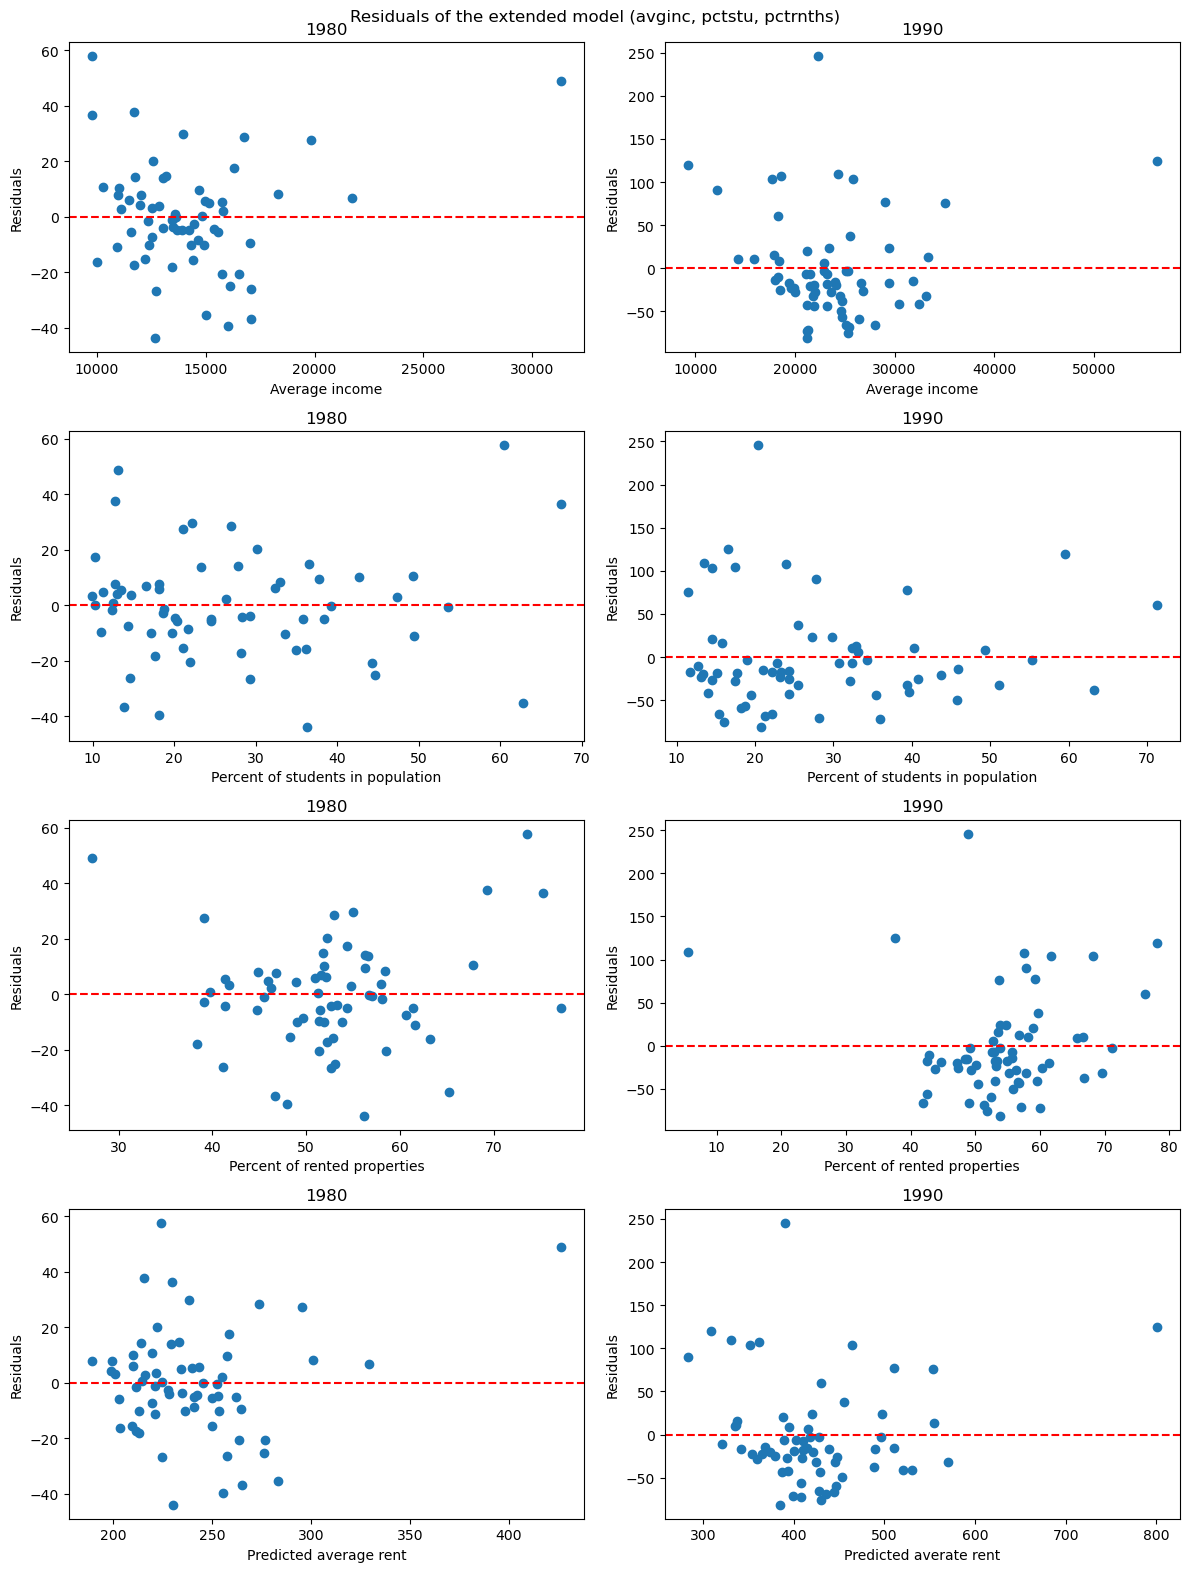

In [19]:
def populate_subplot(ax, x, resid, title, xlabel):
    ax.scatter(x, resid)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Residuals")

# Plot residuals in relation to different params and to predicted values
_, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(12, 16))

populate_subplot(ax1, X80[['avginc']], model80ex.resid, '1980', xlabel="Average income")
populate_subplot(ax2, X90[['avginc']], model90ex.resid, '1990', xlabel="Average income")
populate_subplot(ax3, X80[['pctstu']], model80ex.resid, '1980', xlabel="Percent of students in population")
populate_subplot(ax4, X90[['pctstu']], model90ex.resid, '1990', xlabel="Percent of students in population")
populate_subplot(ax5, X80[['pctrnths']], model80ex.resid, '1980', xlabel="Percent of rented properties")
populate_subplot(ax6, X90[['pctrnths']], model90ex.resid, '1990', xlabel="Percent of rented properties")
populate_subplot(ax7, y80pred, model80ex.resid, '1980', xlabel="Predicted average rent")
populate_subplot(ax8, y90pred, model90ex.resid, '1990', xlabel="Predicted averate rent")

plt.suptitle('Residuals of the extended model (avginc, pctstu, pctrnths)')
plt.tight_layout()
plt.show()

## Testing linear model assumptions
1. Model is linear
2. Matrix is non-random and has rank k
3. Error $u$ has $E(u)=0$ and $var(u)=\sigma^{2}I_{n}$
4. Error $u$ follows normal distribution

1. Model is linear
From the plots of the residuals we can see that there is no function misspecification and so we conclude that model is linear.

2. Matrix is non-random and has rank k
We can not check data for randomness.
If we take a look at the correlation matrix of the parameters we used in the model we see that they are not closely correlated, so we can conclude that data matrix has full rank.

In [20]:
# Correlation matrix
DF[['pop', 'pctstu', 'avginc', 'pctrnths']].corr(numeric_only=True)[['pop', 'pctstu', 'avginc', 'pctrnths']]

,pop,pctstu,avginc,pctrnths
pop,1.000000,-0.432984,0.187568,-0.156864
pctstu,-0.432984,1.000000,-0.175957,0.609148
avginc,0.187568,-0.175957,1.000000,-0.187621
pctrnths,-0.156864,0.609148,-0.187621,1.000000


3. Error $u$ has $E(u)=0$ and $var(u)=\sigma^{2}I_{n}$
We see that mean of residuals is quite close to 0, so there is reason to believe that expected values of the error term is also 0.
From the plots of the residuals we can see that variance is not changing much depending on the values of the regressor, so we can assume that $var(u)=\sigma^{2}I_{n}$.

In [21]:
print("Mean of residuals for extended linear model for 1980: ", np.average(model80ex.resid))
print("Mean of residuals for extended linear model for 1990: ", np.average(model90ex.resid))

Mean of residuals for extended linear model for 1980:  -0.3647985458783456
Mean of residuals for extended linear model for 1990:  -0.2237015745368014


4. Error $u$ follows normal distribution
Using Jaque-Bera test and histograms of the residuals we can conclude that residuals do not follow normal distribution.
What does it mean for our distribution?

In [22]:
print("Jaque-Bera test for residuals of extended linear model for 1980: ", jarque_bera(model80ex.resid))
print("Jaque-Bera test for residuals of extended linear model for 1990: ", jarque_bera(model90ex.resid))

Jaque-Bera test for residuals of extended linear model for 1980:  SignificanceResult(statistic=3.7160393312998616, pvalue=0.15598121967943726)
Jaque-Bera test for residuals of extended linear model for 1990:  SignificanceResult(statistic=52.30118066727505, pvalue=4.394838491788951e-12)


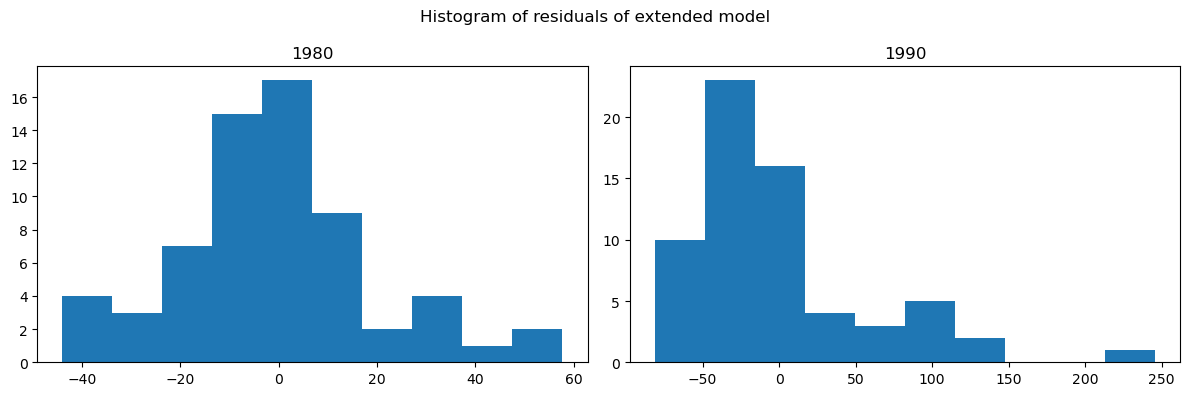

In [23]:
# Plot histogram of residuals for extended model
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(model80ex.resid)
ax2.hist(model90ex.resid)

ax1.set_title('1980')
ax2.set_title('1990')

plt.suptitle('Histogram of residuals of extended model')
plt.tight_layout()
plt.show()

## Testing whether population is 10 times more important that percent of students in the population
For the extended linear model that includes params: 'pop', 'pctstu', 'pctrnths', 'avginc'.

$H_0: \beta_1 - \beta_2 \cdot 10 = 0$ vs $H_1: \beta_1 - \beta_2 \cdot 10 \neq 0$
We can use single linear restriction test
$t_n = \frac{w'\hat\beta - r}{\sqrt{s^2 w'(X'X)^{-1}w}}\sim t_{(n-k)}$
where $w' = [1, -10, 0, 0]$ and $r' = [0, 0, 0, 0]$.
$s^2 = \frac{e'e}{n-k}$
With $n = 64$ and $k = 4$ we will use $t_{(60)} = 2.00$ as critical values for two-sided test with $\alpha = 0.05$.

In [24]:
def t_test(model, X, r):
    beta = model.params.values
    w = np.array(r).T
    e = model.resid
    n = len(X)
    k = len(beta)
    s2 = (e.T@e)/(n-k)
    XX = np.linalg.inv(X.T@X)
    numerator = w.T@beta
    denominator = np.sqrt(s2 * (w.T@XX@w))
    return numerator / denominator

r = [1, -10, 0, 0]
print("T-test value for testing linear restriction for 1980:", t_test(model80ex, X80, r))
print("T-test value for testing linear restriction for 1990:", t_test(model90ex, X90, r))

T-test value for testing linear restriction for 1980: -2.195602452045857
T-test value for testing linear restriction for 1990: -1.0248180225834098


In [25]:
# Same T-test using statsmodels.model.t_test function. Results are matching our results.
test_result = model80ex.t_test('pop = 10 * pctstu')
print("1980")
print(test_result.summary())

test_result = model90ex.t_test('pop = 10 * pctstu')
print()
print("1990")
print(test_result.summary())

1980
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -5.5245      2.516     -2.196      0.032     -10.558      -0.491

1990
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -8.1793      7.981     -1.025      0.310     -24.144       7.786


## Linear regression for change parameters (change in log average income, change in log population, change in log percent students, change in log percent rented houses)

In [26]:
# Linear regression for change parameters
X_change = DF90[['clavginc', 'clpop', 'cpctstu', 'clpctrnths']]
y_change = DF90['clrent']

model_change = sm.OLS(y_change.astype(float), X_change.astype(float)).fit()
y_change_pred = X_change@model_change.params.values

print(model_change.summary())

                                 OLS Regression Results                                
Dep. Variable:                 clrent   R-squared (uncentered):                   0.934
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              211.1
Date:                Mon, 22 Jan 2024   Prob (F-statistic):                    1.31e-34
Time:                        12:13:15   Log-Likelihood:                          32.020
No. Observations:                  64   AIC:                                     -56.04
Df Residuals:                      60   BIC:                                     -47.41
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

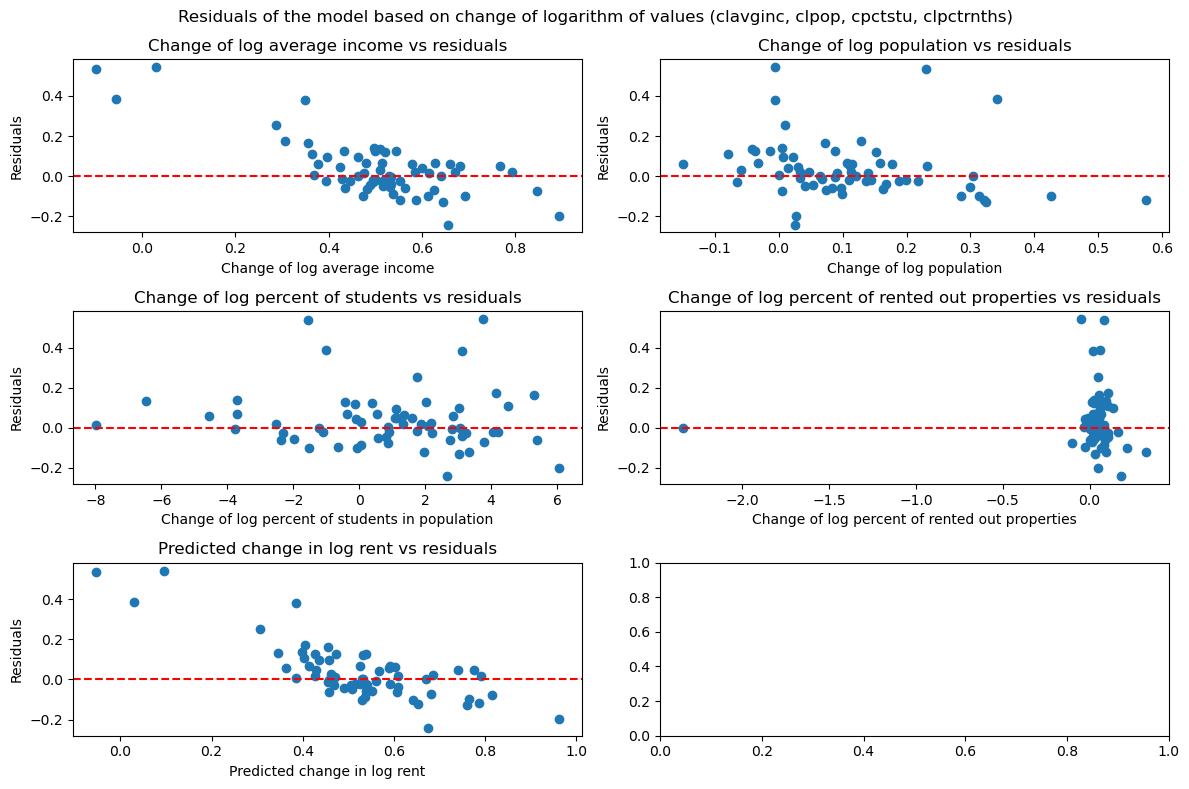

In [27]:
# Plot residuals in relation to different params and to predicted values
_, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 8))

populate_subplot(ax1, X_change[['clavginc']], model_change.resid, 'Change of log average income vs residuals', xlabel="Change of log average income")
populate_subplot(ax2, X_change[['clpop']], model_change.resid, 'Change of log population vs residuals', xlabel="Change of log population")
populate_subplot(ax3, X_change[['cpctstu']], model_change.resid, 'Change of log percent of students vs residuals', xlabel="Change of log percent of students in population")
populate_subplot(ax4, X_change[['clpctrnths']], model_change.resid, 'Change of log percent of rented out properties vs residuals', xlabel="Change of log percent of rented out properties")
populate_subplot(ax5, y_change_pred, model_change.resid, 'Predicted change in log rent vs residuals', xlabel="Predicted change in log rent")

plt.suptitle('Residuals of the model based on change of logarithm of values (clavginc, clpop, cpctstu, clpctrnths)')
plt.tight_layout()
plt.show()

In [28]:
jb_test = jarque_bera(model_change.resid)
jb_test

SignificanceResult(statistic=62.424008537716, pvalue=2.784830564861406e-14)

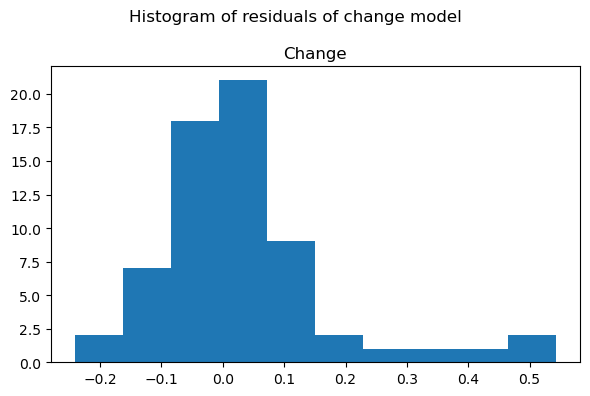

In [29]:
_, (ax) = plt.subplots(1, 1, figsize=(6, 4))

ax.hist(model_change.resid)
ax.set_title('Change')

plt.suptitle('Histogram of residuals of change model')
plt.tight_layout()
plt.show()

In [30]:
print("Mean of residuals for change linear model: ", np.average(model_change.resid))
print("Jaque-Bera test for residuals of change linear model: ", jarque_bera(model_change.resid))

Mean of residuals for change linear model:  0.03608254557216441
Jaque-Bera test for residuals of change linear model:  SignificanceResult(statistic=62.424008537716, pvalue=2.784830564861406e-14)
